# Validate 3b1f

**Goal:** This is one of our great validation regions, so now that my trainings are done, I think it would be nice to evaluate them!

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path += ['../gp-for-flows/','../PyATLASstyle/','../../hh4b/hh4b-plots/'] 

from statUtils import getEigenvariations

from gp import *
from flows import *
from bkgPred import *

from hh4b_plots.phys_utils import get_lumi

import cabinetry
cabinetry.set_logging()

import hist
import pyhf
# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

from hh4b_plots.colors import *


%load_ext autoreload
%autoreload 2

In [2]:
colors = [
    'dodgerblue',
    'darkorange',
    'limegreen',
    'crimson',
    'mediumpurple',
    'brown',
    'deeppink',
    'grey',
    'gold',
    'mediumturquoise'
]

**Concatenate the histograms** 

In [3]:
c = 'val1p1'

#replica=0

fc = f'../gp-for-flows/configs/{c}.json'
with open(fc,'r') as cfile:
    hps = json.load(cfile)

L,H,nb,K,lr,beta,p = hps['L'],hps['H'],hps['nb'],hps['K'],hps['lr'],hps['beta'],hps['p']
colTag = '_'.join(hps['cols'])

modelConfig = f'nsf_rq-coupling_{colTag}_lu_{L}_layers_H_{H}_{nb}_blocks_K_{K}_B_3_lr_{lr}_{beta}_p{p}_iter0'

nSeeds = 25

yrs = ['16','17','18']

In [5]:
hdict = {i: {yr:{} for yr in yrs} for i in range(10)} # GP + flow prediction

hAll = {i: {} for i in range(10)}

for i in range(10):
    
    subDir = f'data161718-MAY21_3b1f_{i}of10_detaCut_ggf'

    modelDir = f'../gp-for-flows/models/{subDir}'

    
    for yr in yrs:
        with open(f'{modelDir}/{modelConfig}/hists_gp_100k_pipe_{yr}.json','r') as hfile:
            out = json.load(hfile)

        for k in out.keys():
            hdict[i][yr][k] = np.array( out[k])
            
            
    for k in hdict[i]['16'].keys():
        if 'std' in k: 
            continue

        hAll[i][k] = np.vstack([hd[k] for yr,hd in hdict[i].items()]).sum(axis=0)
    
    
    for c, tag in product(myVars+['X_hh_dEta_hh_m_hh'],['','_Xwt_cut']):
    
        k = f'{c}_SR{tag}'

        # Correlated errors
        stack = np.vstack([hAll[i][f'{k}_{j}'] for j in range(nSeeds)])
        hAll[i][f"{k}_std"] = np.sqrt(np.sum((stack - hAll[i][f'{k}_mean'])**2, axis=0) / (nSeeds-1))


**Save the histograms**

In [6]:
yrs

['16', '17', '18']

**Load in the data**

In [7]:
fnames = [f'../data/RR/cryptotuples/data{yr}.root' for yr in yrs]

In [8]:
hc_vars = [f'{v}_h{i}' for v, i in product(['pT','eta','phi'],[1,2])]

load_cols = d_cols + ['ntag','X_wt_tag','pass_vbf_sel','minQ','event_number'] + hc_vars

In [9]:
myRanges,edg_3d = get_default_bins()

In [10]:
dfs = []

for fname in fnames:
    print(fname)
    with uproot.open(fname) as f:
        
        dfi = f['sig'].arrays(load_cols,library='pd')
        mi = dfi.eval('ntag == 3 & minQ == 1 & ~pass_vbf_sel')


        dfs.append( dfi[mi] )
        
df = pd.concat(dfs).reset_index()

../data/RR/cryptotuples/data16.root
../data/RR/cryptotuples/data17.root
../data/RR/cryptotuples/data18.root


In [11]:


for i in range(10):
    
    
    # Get the by year norms
    ns = np.array([0.1 * np.sum(dfi['X_wt_tag'] < 1.5) / np.sum(hdict[i][yr]['X_wt_tag_SR_mean'][:10]) 
          for yr, dfi in zip(yrs, dfs)])

    print(ns)
    
    
    for c, tag in product(myVars+['X_hh_dEta_hh_m_hh'],['','_Xwt_cut']):

        k = f'{c}_SR{tag}'

        # Weighted mean
        hAll[i][f"{k}_wmean"] = np.sum(np.vstack([n*hdict[i][yr][f'{k}_mean'] 
                                                  for yr, n in zip(yrs,ns)]),axis=0)
        
        for j in range(nSeeds):
            hAll[i][f'{k}_w{j}'] = np.sum(np.vstack([n*hdict[i][yr][f'{k}_{j}'] 
                                                    for yr, n in zip(yrs,ns)]),axis=0)
        
        # Correlated errors
        stack = np.vstack([hAll[i][f'{k}_w{j}'] for j in range(nSeeds)])
        hAll[i][f"{k}_wstd"] = np.sqrt(np.sum((stack - hAll[i][f'{k}_wmean'])**2, axis=0) / (nSeeds-1))


[0.92447597 1.01889755 1.04602997]
[1.05830185 1.02656285 1.01986532]
[1.05386057 1.06891254 1.07543336]
[1.07534929 1.02714864 0.99829499]
[1.03149556 0.99392898 0.99740339]
[0.99944456 1.00494267 1.02910454]
[1.11394618 1.0907871  1.033955  ]
[1.08874421 1.02896458 1.01596406]
[1.02699699 0.97234797 0.97830763]
[1.03739125 0.99233676 0.96187502]


In [12]:
df

index      X_hh   dEta_hh        m_hh  ntag  X_wt_tag  pass_vbf_sel  \
0            53  1.467443  0.521842  346.689636     3  2.560099         False   
1            79  0.828958  0.916910  379.280182     3  3.173869         False   
2            99  1.492995  0.952194  546.792297     3  1.702670         False   
3           112  1.531847  1.225301  296.596558     3  3.407134         False   
4           121  1.411201  0.321892  368.646271     3  1.323189         False   
...         ...       ...       ...         ...   ...       ...           ...   
224955  1093899  0.498509  0.586743  397.558258     3  2.605787         False   
224956  1093903  1.336083  0.046392  353.562836     3  1.617909         False   
224957  1093912  1.573290  0.029824  381.888885     3  4.084166         False   
224958  1093921  1.581284  1.317051  375.844177     3  1.372213         False   
224959  1093938  0.744907  0.860332  354.002045     3  0.841554         False   

        minQ  event_number       pT_h1       pT_h2    eta_h1    eta_h2  \
0          1      83841373  149.983429  102.520706  1.631475  1.109633   
1          1      86799611  146.502335  120.179276  0.399481 -0.517428   
2          1     141321060  241.014481  199.138428  2.067981  1.115787   
3          1      90591071  110.373367   49.891491 -0.836997  0.388304   
4          1      45732946  152.930740  122.134880 -0.912246 -1.234138   
...      ...           ...         ...         ...       ...       ...   
224955     1     806247908  159.501740  131.044601 -1.567598 -0.980855   
224956     1     805997165  166.173370   92.438057  0.579261  0.532870   
224957     1     757039987  179.034241  136.674576  1.968435  1.998259   
224958     1     754778998  126.210114   90.553757  1.027076 -0.289975   
224959     1     771889825  195.842651   50.137360  0.748235 -0.112098   

          phi_h1    phi_h2  
0       2.273143 -0.858570  
1      -0.173411  3.000867  
2      -1.730458  1.064923  
3      -1.092548  2.234940  
4      -0.831750  2.287559  
...          ...       ...  
224955  1.306085 -1.910398  
224956  1.154802 -1.837148  
224957  2.408854 -0.173067  
224958  3.079650 -0.083549  
224959 -0.299914  2.757251  

[224960 rows x 15 columns]

In [13]:
edg_3d

[[0, 0.95, 1.6],
 [0, 0.5, 1, inf],
 array([  0., 305., 333., 363., 395., 431., 470., 512., 558., 608., 663.,
        723., 788., 858., 936.,  inf])]

In [14]:
d_cols

['X_hh', 'dEta_hh', 'm_hh']

WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.


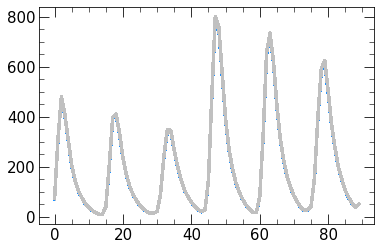

In [15]:
i =0
plt.plot(hAll[i][f"{k}_mean"],color=colors[i])
plt.plot(hAll[i][f"{k}_wmean"],color='silver')

WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.
WARNING - matplotlib.font_manager - findfont: Font family ['TeX Gyre Heros'] not found. Falling back to DejaVu Sans.


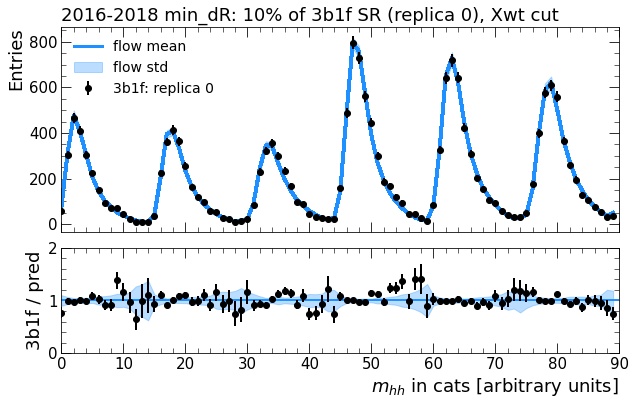

In [16]:
k = '_SR_Xwt_cut'



fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":0.1})





for c in colors:
    
    nom = hAll[i][f'X_hh_dEta_hh_m_hh{k}_mean']
    std = hAll[i][f'X_hh_dEta_hh_m_hh{k}_std']
        
    ax1.plot(nom,color=c,label='flow mean',lw=3)   

    ax1.fill_between(range(len(nom)),nom+std,nom-std,color=c,alpha=0.3,
                     label='flow std')

    ax2.fill_between(range(len(nom)),1+std/nom,1-std/nom,
                 color=c,alpha=0.3)
    
    ax2.plot([0,len(nom)], [1]*2,lw=2,color=c)

    
    break
    
    
for i, c in enumerate(colors[6:]):
    
    mask = df.eval(f'X_wt_tag > 1.5 & event_number % 10 == {i}')

    h_3d = np.histogramdd(df.loc[mask,d_cols].values,edg_3d)[0].flatten()

    ax1.errorbar(range(len(nom)), h_3d, np.sqrt(h_3d), 
                 lw=0, elinewidth=2,marker='o',color='k',
                 label=f'3b1f: replica {i}')


    ax2.errorbar(range(len(nom)), h_3d/nom, np.sqrt(h_3d)/nom, 
                 lw=0, elinewidth=2,marker='o',color='k')

    break
    
    
ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
ax1.set_title(f'2016-2018 min_dR: 10% of 3b1f SR (replica {i}), Xwt cut',x=0,loc='left')
ax2.set_ylabel('3b1f / pred',fontsize=18)

ax1.legend()
ax1.set_xlim(0,90)
ax2.set_ylim(0,2)



#plt.savefig(f'{figDir}/m_hh_cats.pdf',bbox_inches='tight')
plt.show()

In [17]:
bins = np.linspace(-5,5,25)

zbins = bins.copy()

zbins[0] = -np.inf
zbins[-1] = np.inf

In [18]:
mus = pd.DataFrame(0,range(10),range(10))
stds = pd.DataFrame(0,range(10),range(10))

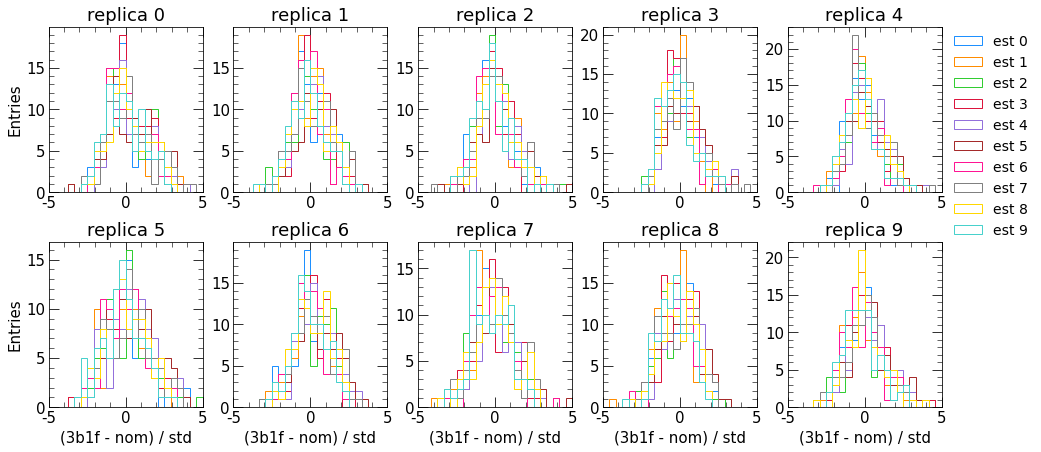

In [19]:
fig, axes = plt.subplots(figsize=(16,7),nrows=2,ncols=5,#sharex=True,
                              gridspec_kw={"height_ratios": [.5,.5],
                                           "hspace":0.3, "wspace":.2})
axes=axes.reshape(-1)

for i,c in enumerate(colors): # trainings
    
    
    nom = hAll[i][f'X_hh_dEta_hh_m_hh{k}_mean']
    std = hAll[i][f'X_hh_dEta_hh_m_hh{k}_std']
    
    
    for j,ax in enumerate(axes):
        
        mask = df.eval(f'X_wt_tag > 1.5 & event_number % 10 == {j}')

        h_3d = np.histogramdd(df.loc[mask,d_cols].values,edg_3d,)[0].flatten()


        z = (h_3d-nom)/std
        
        
        mu, sd = np.mean(z), np.std(z)
        mus.loc[j,i] = mu
        stds.loc[j,i] = sd
        
        ax.hist(z,bins=bins, color=c, histtype='step', label=f'est {i}')
        
        ax.set_title(f'replica {j}')
        ax.set_xlim(-5,5)

for i in [0,5]:
    axes[i].set_ylabel('Entries')
for ax in axes[5:]:
    ax.set_xlabel('(3b1f - nom) / std')
    
    
axes[4].legend(bbox_to_anchor=(1,1.03),loc='upper left',fontsize=14)

plt.show()

**Q:** If I had a way to constrain the normalization - would this fix things?


**Idea:** I could fit the `X_wt_tag` distribution??

- In general I could fit train with negative weights and fit the components
- But maybe even just looking at the `X_wt_tag` < 1.5 data would be useful?

(-0.5, 9.5)

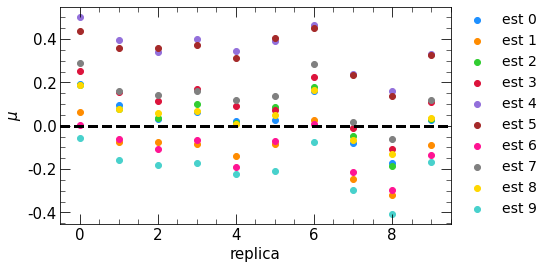

In [20]:
plt.figure(figsize=(7,4))

for i,c in enumerate(colors):
    plt.scatter(range(10),mus[i],color=c, label=f'est {i}')
    
plt.plot([-0.5,9.5],[0]*2,'k',ls='--')

plt.xlabel('replica')
plt.ylabel('$\mu$')
plt.legend(bbox_to_anchor=(1,1.03))

plt.xlim(-0.5,9.5)

(-0.5, 9.5)

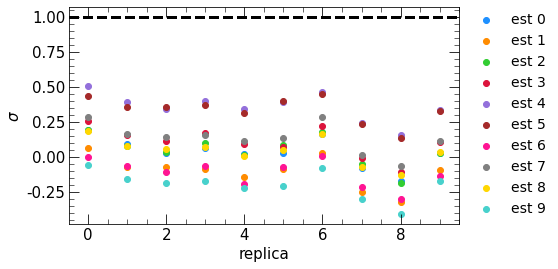

In [21]:
plt.figure(figsize=(7,4))

for i,c in enumerate(colors):
    plt.scatter(range(10),mus[i],color=c, label=f'est {i}')
    
plt.plot([-0.5,9.5],[1]*2,'k',ls='--')

plt.xlabel('replica')
plt.ylabel('$\sigma$')
plt.legend(bbox_to_anchor=(1,1.03))

plt.xlim(-0.5,9.5)

In [22]:
from bkgPred import get_default_bins

In [23]:
bi = get_default_bins('X_wt_tag')

In [24]:
bi

([(200, 1200),
  (250, 1250),
  (1, 6.5),
  (0, 400),
  (0, 400),
  (-3, 3),
  (-3, 3),
  (-0.5, 3.141592653589793),
  (0, 7.5)],
 [[0, 0.95, 1.6],
  [0, 2.5, 3.6, inf],
  array([  0., 305., 333., 363., 395., 431., 470., 512., 558., 608., 663.,
         723., 788., 858., 936.,  inf])])

In [25]:
bi = np.linspace(0,7.5,51)
xi = 0.5 * (bi[1:] + bi[:-1])

In [26]:
norms = pd.DataFrame(0,range(10),yrs+['all'])

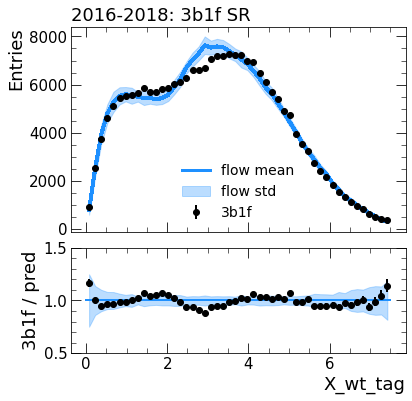

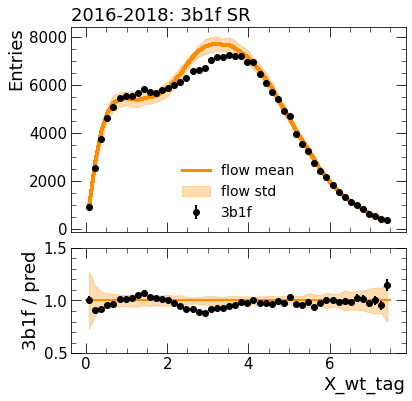

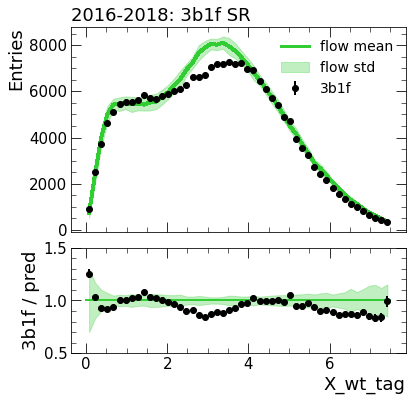

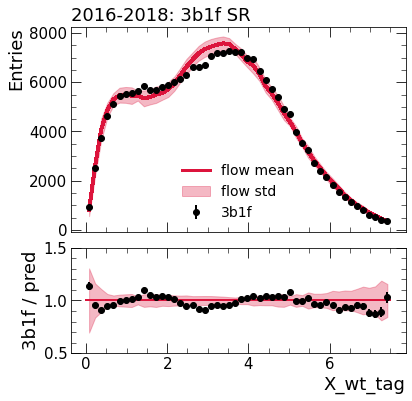

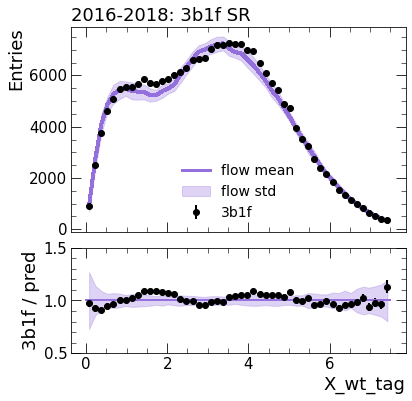

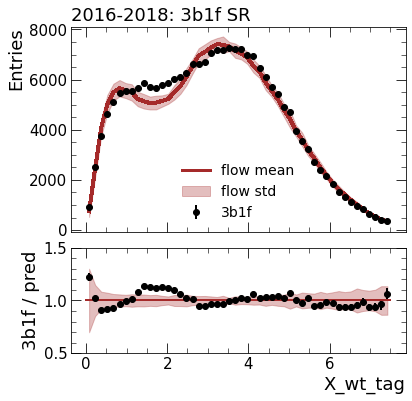

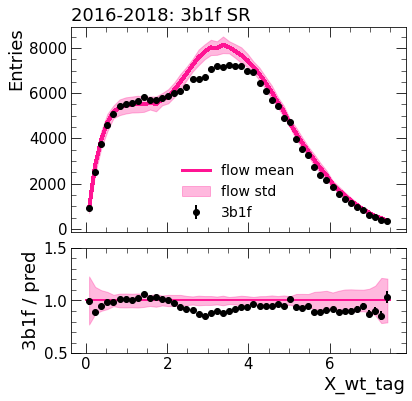

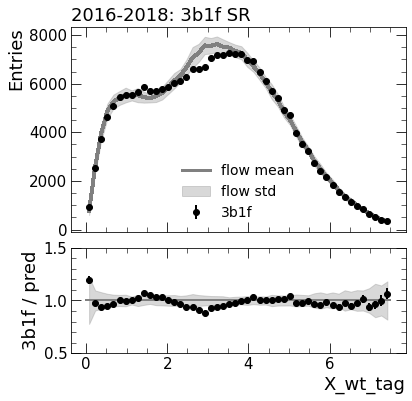

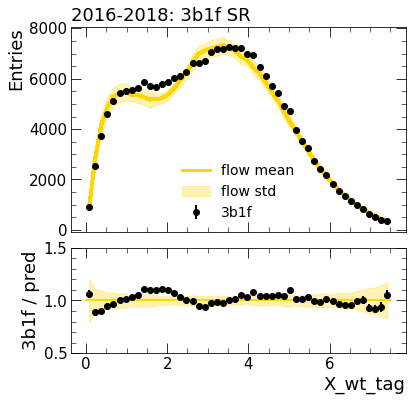

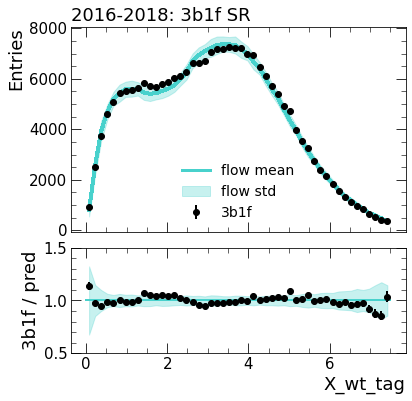

In [27]:
for i,c in enumerate(colors):

    fig, (ax1,ax2) = plt.subplots(figsize=(6,6),nrows=2,sharex=True,
                                  gridspec_kw={"height_ratios": [.66,.34],
                                               "hspace":0.1})
    
    nom = 10*hAll[i]['X_wt_tag_SR_mean'].copy()
    std = 10*hAll[i]['X_wt_tag_SR_std'].copy()
        
    hi = np.histogram(df['X_wt_tag'].values,bi)[0].flatten()

    ax1.errorbar(xi, hi, np.sqrt(hi), 
                 lw=0, elinewidth=2,marker='o',color='k',
                 label=f'3b1f')


    s = np.sum(hi[:10]) / np.sum(nom[:10])
    
    norms.loc[i,'all'] = s
    
    nom *= s
    std *= s
        
    ax1.plot(xi,nom,color=c,label='flow mean',lw=3)   

    ax1.fill_between(xi,nom+std,nom-std,color=c,alpha=0.3,
                     label='flow std')

    ax2.fill_between(xi,1+std/nom,1-std/nom,
                 color=c,alpha=0.3)
    
    ax2.errorbar(xi, hi/nom, np.sqrt(hi)/nom, 
                 lw=0, elinewidth=2,marker='o',color='k')


    
    ax2.plot([0,7.5], [1]*2,lw=2,color=c)

        
    ax2.set_xlabel('X_wt_tag',x=1,ha='right',fontsize=18)
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title(f'2016-2018: 3b1f SR',x=0,loc='left')
    ax2.set_ylabel('3b1f / pred',fontsize=18)

    ax1.legend()
    ax2.set_ylim(0.5,1.5)

    #plt.savefig(f'{figDir}/m_hh_cats.pdf',bbox_inches='tight')
    plt.show()

In [28]:
norms['all']

0    1.009404
1    1.029977
2    1.068880
3    1.021924
4    1.004038
5    1.016263
6    1.064920
7    1.034823
8    0.987396
9    0.985550
Name: all, dtype: float64

**Q:** Would it be better to derive a normalization factor for _each_ of the 3 years separately?

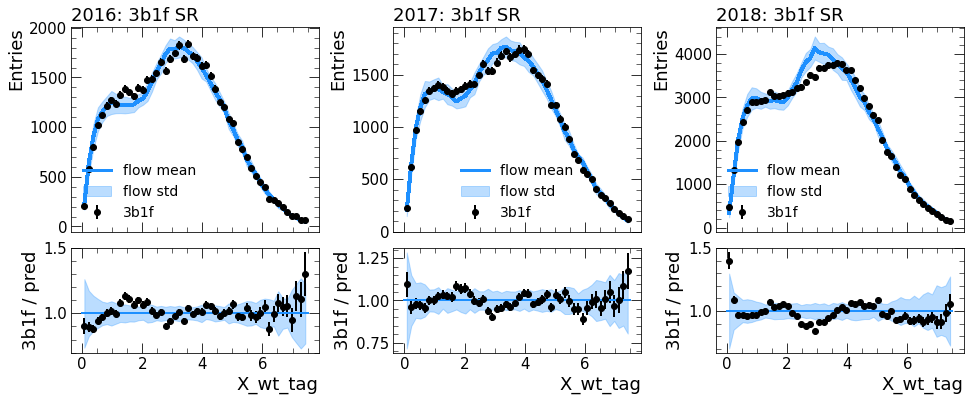

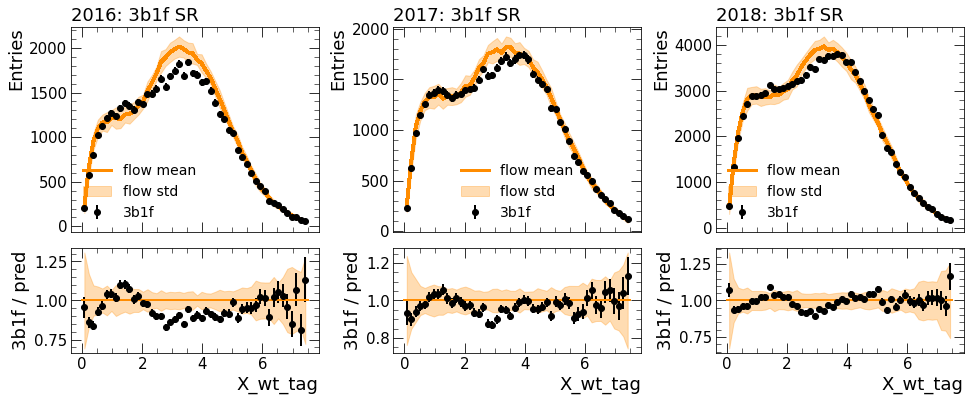

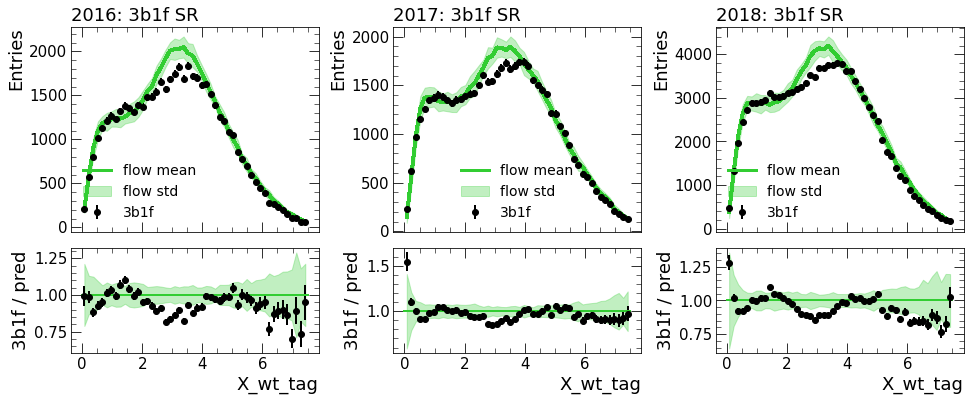

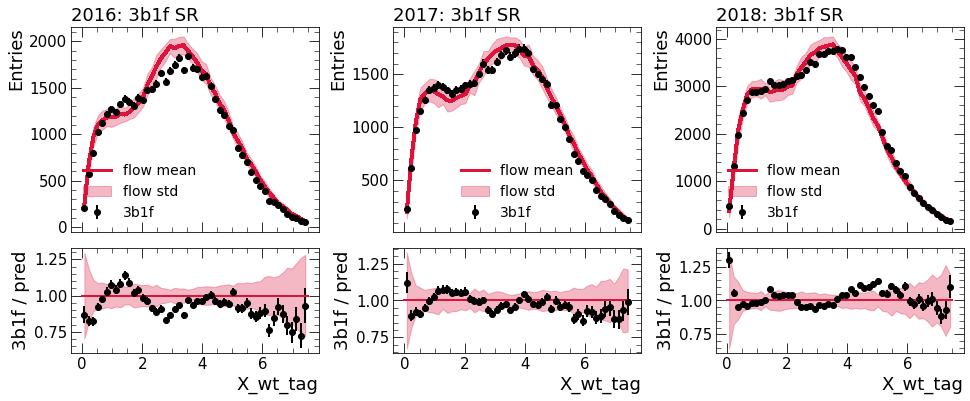

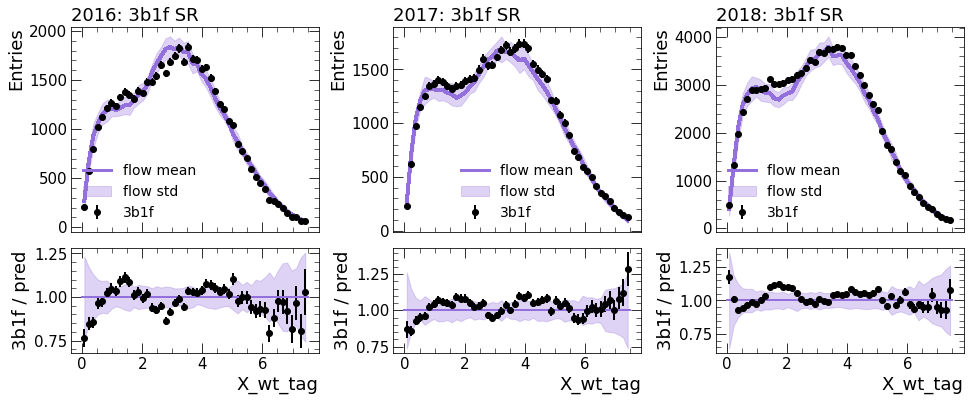

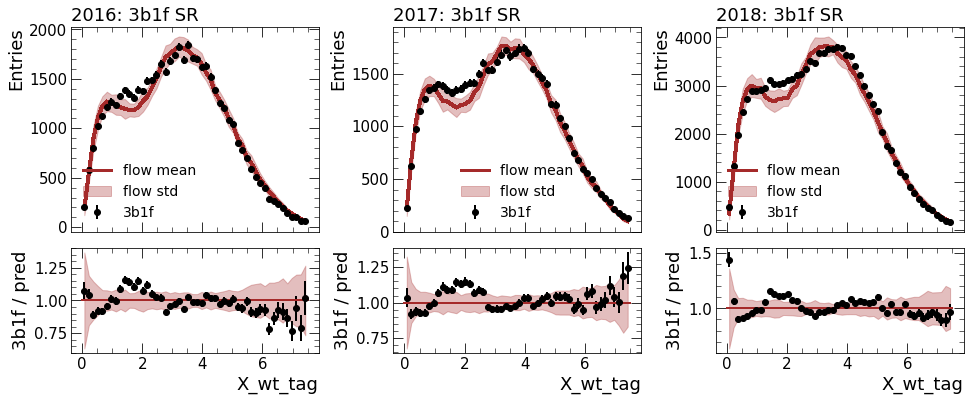

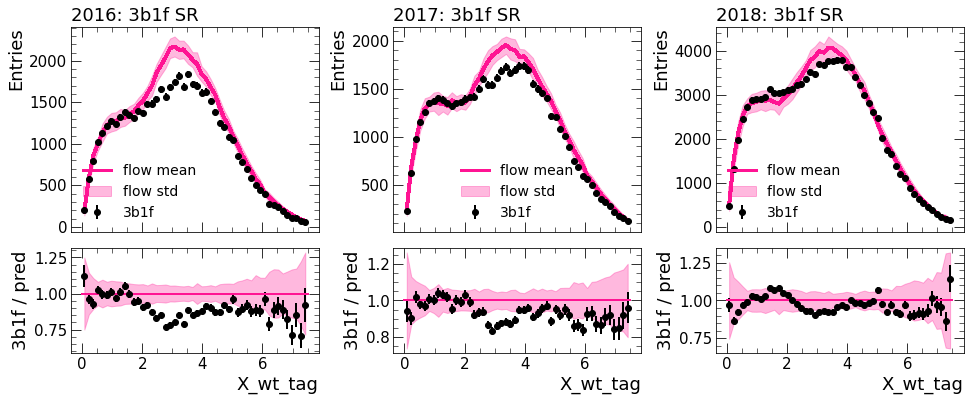

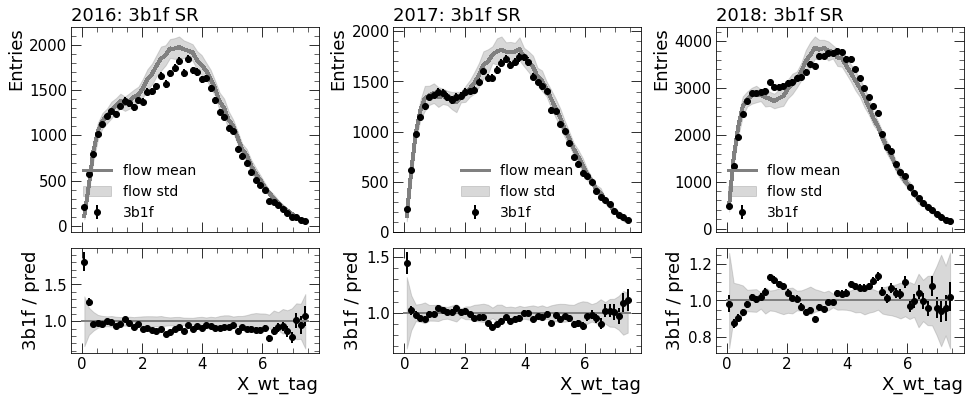

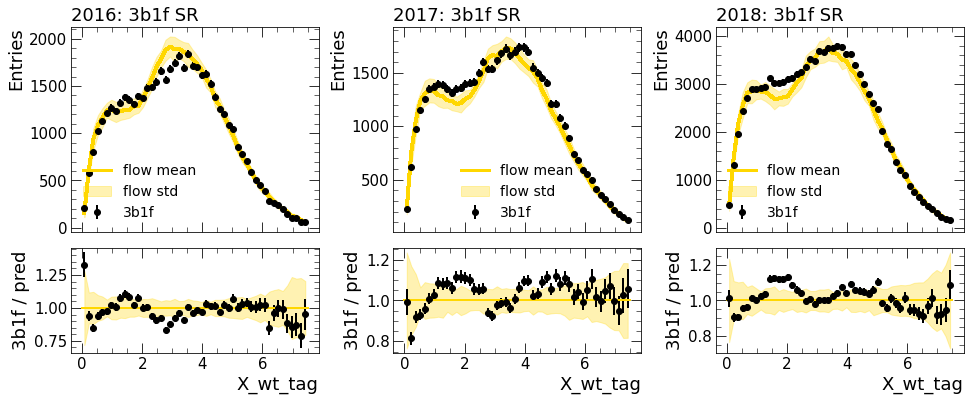

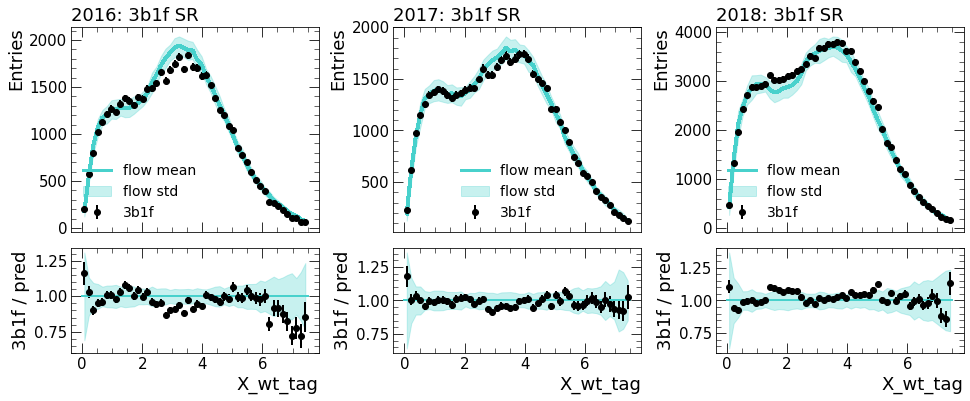

In [29]:
for i,c in enumerate(colors):

    fig, axes = plt.subplots(figsize=(16,6),nrows=2,ncols=3,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":0.1,"wspace":0.3})
    
    for yr,dfi, (ax1,ax2) in zip(yrs,dfs,axes.T):
        
        nom = 10*hdict[i][yr]['X_wt_tag_SR_mean'].copy()
        std = 10*hdict[i][yr]['X_wt_tag_SR_std'].copy()

        hi = np.histogram(dfi['X_wt_tag'].values,bi)[0].flatten()

        ax1.errorbar(xi, hi, np.sqrt(hi), 
                     lw=0, elinewidth=2,marker='o',color='k',
                     label=f'3b1f')


        s = np.sum(hi[:10]) / np.sum(nom[:10])

        
        norms.loc[i,yr] = s
        
        nom *= s
        std *= s
        
        ax1.plot(xi,nom,color=c,label='flow mean',lw=3)   

        ax1.fill_between(xi,nom+std,nom-std,color=c,alpha=0.3,
                         label='flow std')

        ax2.fill_between(xi,1+std/nom,1-std/nom,
                         color=c,alpha=0.3)
    
        ax2.errorbar(xi, hi/nom, np.sqrt(hi)/nom, 
                     lw=0, elinewidth=2,marker='o',color='k')



        ax2.plot([0,7.5], [1]*2,lw=2,color=c)

        ax2.set_xlabel('X_wt_tag',x=1,ha='right',fontsize=18)
        ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
        ax1.set_title(f'20{yr}: 3b1f SR',x=0,loc='left')
        ax2.set_ylabel('3b1f / pred',fontsize=18)

        ax1.legend()
        #ax2.set_ylim(0.5,1.5)

    #break


#plt.savefig(f'{figDir}/m_hh_cats.pdf',bbox_inches='tight')
plt.show()

In [30]:
norms

16        17        18       all
0  0.924476  1.018898  1.046030  1.009404
1  1.058302  1.026563  1.019865  1.029977
2  1.053861  1.068913  1.075433  1.068880
3  1.075349  1.027149  0.998295  1.021924
4  1.031496  0.993929  0.997403  1.004038
5  0.999445  1.004943  1.029105  1.016263
6  1.113946  1.090787  1.033955  1.064920
7  1.088744  1.028965  1.015964  1.034823
8  1.026997  0.972348  0.978308  0.987396
9  1.037391  0.992337  0.961875  0.985550

**Q:** For the _overall_ distribution, do I get better performace if I normalize each year separately or together?

**Plan:** Overlay the inclusive norm and the by year norms to see which is better for the X_wt shape. (Note - another small follow-up would be to do the same shape comparison for the 3d discriminant.

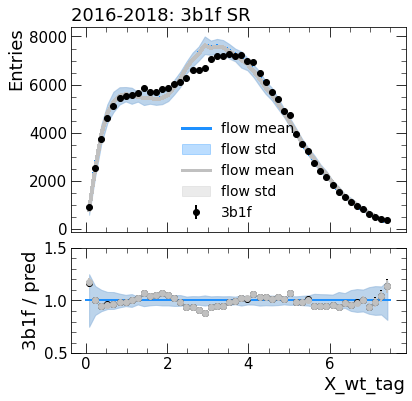

In [31]:
for i,c in enumerate(colors):

    fig, (ax1,ax2) = plt.subplots(figsize=(6,6),nrows=2,sharex=True,
                                  gridspec_kw={"height_ratios": [.66,.34],
                                               "hspace":0.1})
    
    
    nom = 10*hAll[i]['X_wt_tag_SR_mean'].copy()
    std = 10*hAll[i]['X_wt_tag_SR_std'].copy()
        
    hi = np.histogram(df['X_wt_tag'].values,bi)[0].flatten()

    ax1.errorbar(xi, hi, np.sqrt(hi), 
                 lw=0, elinewidth=2,marker='o',color='k',
                 label=f'3b1f')


    s = np.sum(hi[:10]) / np.sum(nom[:10])
    
    nom *= s
    std *= s
        
    ax1.plot(xi,nom,color=c,label='flow mean',lw=3)   

    ax1.fill_between(xi,nom+std,nom-std,color=c,alpha=0.3,
                     label='flow std')

    ax2.fill_between(xi,1+std/nom,1-std/nom,
                 color=c,alpha=0.3)
    
    ax2.errorbar(xi, hi/nom, np.sqrt(hi)/nom, 
                 lw=0, elinewidth=2,marker='o',color='k')

    
    ax2.plot([0,7.5], [1]*2,lw=2,color=c)


    
    # Overlay the ... norm
    nom = 10*hAll[i]['X_wt_tag_SR_wmean']
    std = 10*hAll[i]['X_wt_tag_SR_wstd']
    

    c='silver'
    
    ax1.plot(xi,nom,color=c,label='flow mean',lw=3)   

    ax1.fill_between(xi,nom+std,nom-std,color=c,alpha=0.3,
                     label='flow std')
    
    ax2.fill_between(xi,1+std/nom,1-std/nom,
                 color=c,alpha=0.3)
    
    ax2.errorbar(xi, hi/nom, np.sqrt(hi)/nom, 
                 lw=0, elinewidth=2,marker='o',color=c)

    
    
        
    ax2.set_xlabel('X_wt_tag',x=1,ha='right',fontsize=18)
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title(f'2016-2018: 3b1f SR',x=0,loc='left')
    ax2.set_ylabel('3b1f / pred',fontsize=18)

    ax1.legend()
    ax2.set_ylim(0.5,1.5)

    break

    #plt.savefig(f'{figDir}/m_hh_cats.pdf',bbox_inches='tight')
    plt.show()

In [32]:
norms.loc[i,'all']

1.0094044294943896

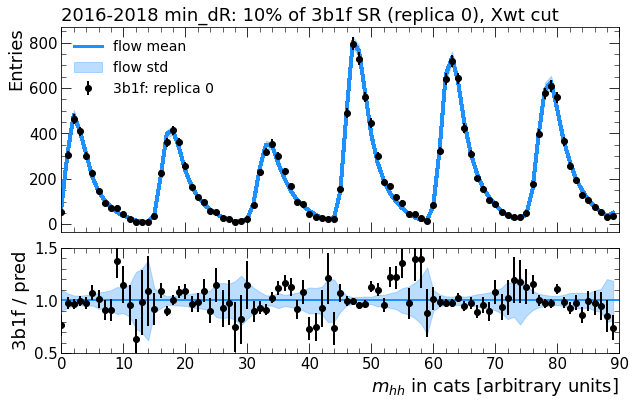

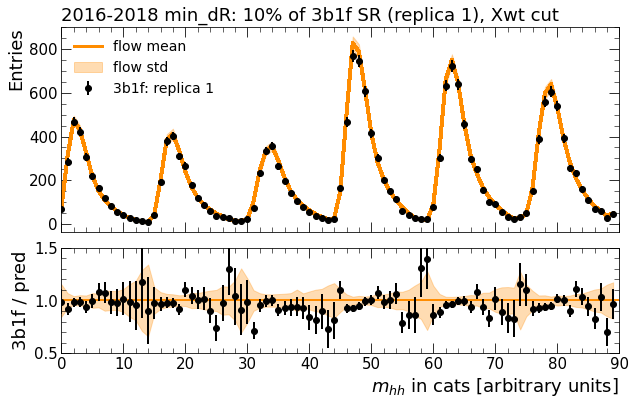

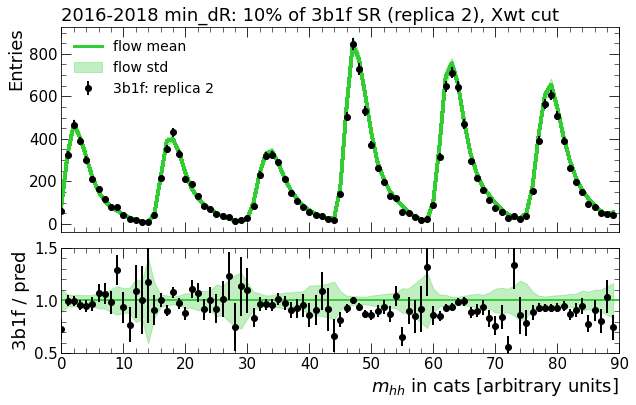

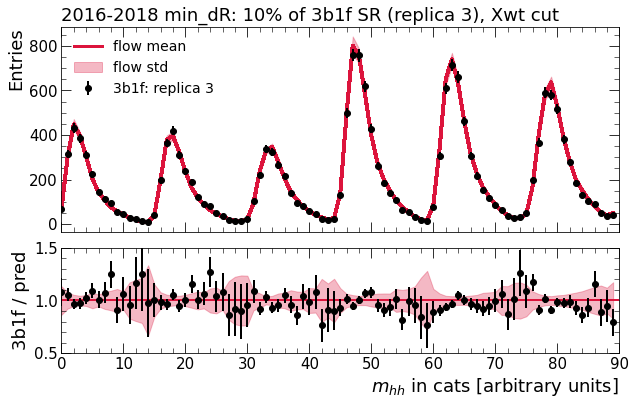

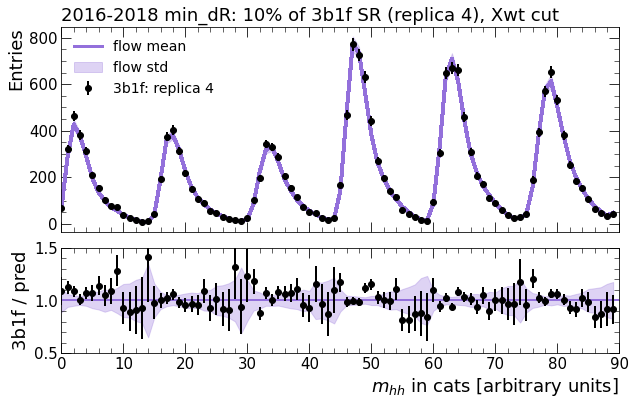

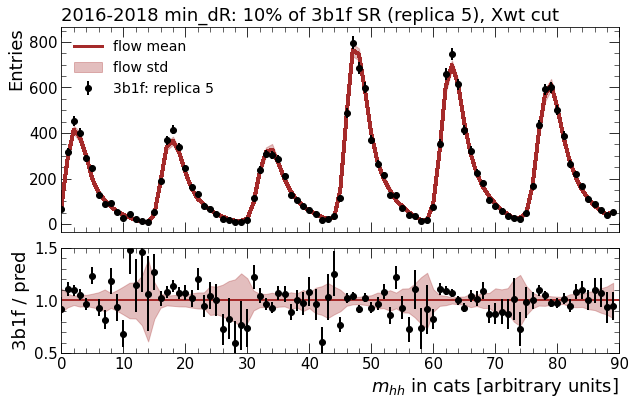

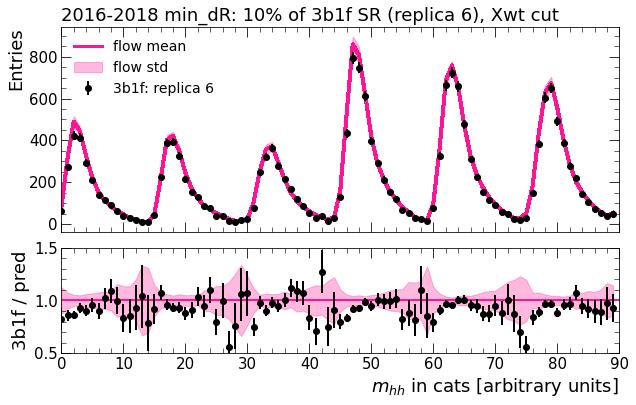

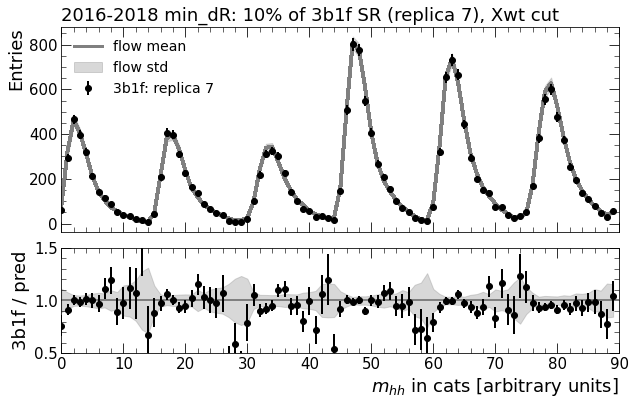

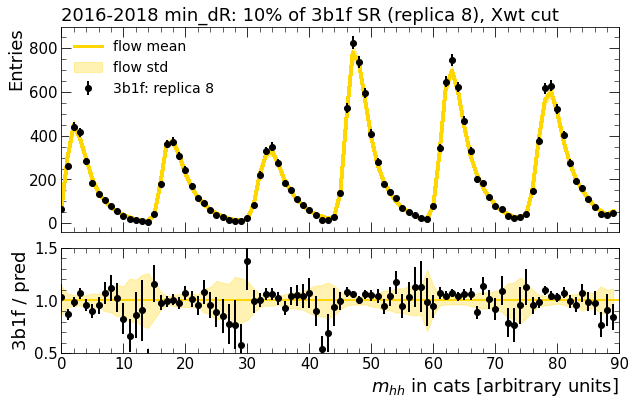

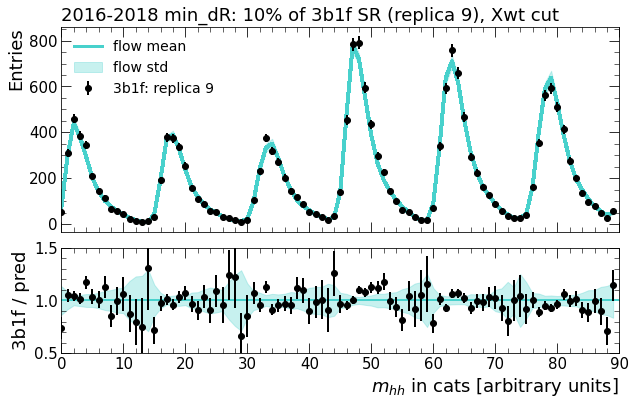

In [36]:
#i = 0
k = '_SR_Xwt_cut'

for i, c in enumerate(colors):
    
    fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                              gridspec_kw={"height_ratios": [.66,.34],
                                           "hspace":0.1})
    
    nom = hAll[i][f'X_hh_dEta_hh_m_hh{k}_mean'].copy()
    std = hAll[i][f'X_hh_dEta_hh_m_hh{k}_std'].copy()
        
    s = norms.loc[i,'all']
        
    nom *= s
    std *= s
        
    ax1.plot(nom,color=c,label='flow mean',lw=3)   

    ax1.fill_between(range(len(nom)),nom+std,nom-std,color=c,alpha=0.3,
                     label='flow std')

    ax2.fill_between(range(len(nom)),1+std/nom,1-std/nom,
                 color=c,alpha=0.3)
    
    ax2.plot([0,len(nom)], [1]*2,lw=2,color=c)

        
    mask = df.eval(f'X_wt_tag > 1.5 & event_number % 10 == {i}')

    h_3d = np.histogramdd(df.loc[mask,d_cols].values, edg_3d)[0].flatten()

    ax1.errorbar(range(len(nom)), h_3d, np.sqrt(h_3d), 
                 lw=0, elinewidth=2,marker='o',color='k',
                 label=f'3b1f: replica {i}')


    ax2.errorbar(range(len(nom)), h_3d/nom, np.sqrt(h_3d)/nom, 
                 lw=0, elinewidth=2,marker='o',color='k')

    ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title(f'2016-2018 min_dR: 10% of 3b1f SR (replica {i}), Xwt cut',x=0,loc='left')
    ax2.set_ylabel('3b1f / pred',fontsize=18)

    ax1.legend()
    ax1.set_xlim(0,90)
    ax2.set_ylim(0.5,1.5)

    figDir = f'figures/data161718-MAY21_3b1f_{i}of10_detaCut_ggf/'
    plt.savefig(f'{figDir}/m_hh_cats_SR_Xwt_cut.pdf',bbox_inches='tight')
    plt.show()
    
    #break

**Wooooo! I think this looks p great now** :)

Sanity check the replicas again?

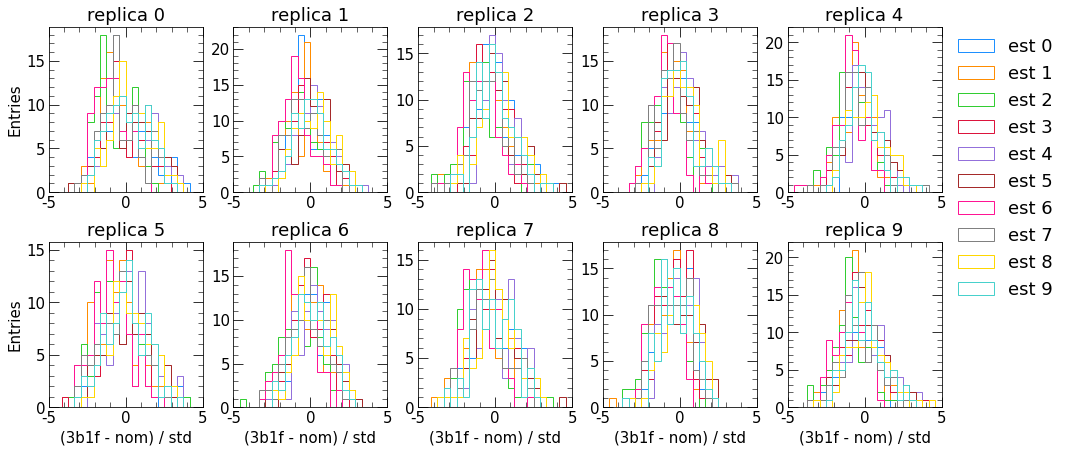

In [34]:
fig, axes = plt.subplots(figsize=(16,7),nrows=2,ncols=5,#sharex=True,
                              gridspec_kw={"height_ratios": [.5,.5],
                                           "hspace":0.3, "wspace":.2})
axes=axes.reshape(-1)

for i,c in enumerate(colors): # trainings
    
    
    nom = hAll[i][f'X_hh_dEta_hh_m_hh{k}_mean'].copy()
    std = hAll[i][f'X_hh_dEta_hh_m_hh{k}_std'].copy()
    
    s = norms.loc[i,'all']
    
    nom *= s
    std *= s
    
    for j,ax in enumerate(axes):
        
        mask = df.eval(f'X_wt_tag > 1.5 & event_number % 10 == {j}')

        h_3d = np.histogramdd(df.loc[mask,d_cols].values,edg_3d,)[0].flatten()


        z = (h_3d-nom)/std
        
        
        mu, sd = np.mean(z), np.std(z)
        mus.loc[j,i] = mu
        stds.loc[j,i] = sd
        
        ax.hist(z,bins=bins, color=c, histtype='step', label=f'est {i}')
        
        ax.set_title(f'replica {j}')
        ax.set_xlim(-5,5)

for i in [0,5]:
    axes[i].set_ylabel('Entries')
for ax in axes[5:]:
    ax.set_xlabel('(3b1f - nom) / std')
    
    
axes[4].legend(bbox_to_anchor=(1,1.03),loc='upper left',fontsize=18)

plt.show()